# COCO object detection

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai.vision import *
from fastai.core import *
import json
from collections import defaultdict
import pdb
import pixiedust
import numpy as np

Pixiedust database opened successfully


## Data

In [5]:
coco = untar_data(URLs.COCO_SAMPLE)

In [6]:
img_dir = coco/'train_sample'
annotations = coco/'annotations'/'train_sample.json'

In [7]:
(coco/'annotations').ls()

[PosixPath('/home/gosia/.fastai/data/coco_sample/annotations/train_sample.json')]

In [8]:
img_list = ImageList.from_folder(img_dir)

In [9]:
img_list

ImageList (21837 items)
Image (3, 487, 600),Image (3, 480, 640),Image (3, 500, 375),Image (3, 425, 640),Image (3, 640, 513)
Path: /home/gosia/.fastai/data/coco_sample/train_sample

In [10]:
#image size
sz = 224

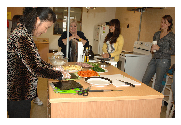

In [11]:
show_image(img_list[3])

In [12]:
with open(annotations) as f:
    train_json = json.load(f)

In [13]:
ncat = len(train_json['categories'])
train_json['categories']

[{'id': 62, 'name': 'chair'},
 {'id': 63, 'name': 'couch'},
 {'id': 72, 'name': 'tv'},
 {'id': 75, 'name': 'remote'},
 {'id': 84, 'name': 'book'},
 {'id': 86, 'name': 'vase'}]

In [14]:
train_json

{'categories': [{'id': 62, 'name': 'chair'},
  {'id': 63, 'name': 'couch'},
  {'id': 72, 'name': 'tv'},
  {'id': 75, 'name': 'remote'},
  {'id': 84, 'name': 'book'},
  {'id': 86, 'name': 'vase'}],
 'annotations': [{'image_id': 318219,
   'bbox': [505.24, 0.0, 47.86, 309.25],
   'category_id': 72},
  {'image_id': 318219,
   'bbox': [470.68, 0.0, 45.93, 191.86],
   'category_id': 72},
  {'image_id': 318219,
   'bbox': [442.51, 0.0, 43.39, 119.87],
   'category_id': 72},
  {'image_id': 554625,
   'bbox': [380.74, 112.85, 40.62, 248.82],
   'category_id': 72},
  {'image_id': 554625,
   'bbox': [339.13, 32.99, 32.99, 175.5],
   'category_id': 72},
  {'image_id': 554625,
   'bbox': [359.55, 68.79, 46.02, 202.79],
   'category_id': 72},
  {'image_id': 554625,
   'bbox': [322.48, 0.0, 47.25, 158.32],
   'category_id': 72},
  {'image_id': 554625,
   'bbox': [306.61, 0.33, 28.95, 71.64],
   'category_id': 72},
  {'image_id': 118113,
   'bbox': [284.04, 180.23, 43.78, 14.87],
   'category_id': 84

In [15]:
# count the number of annotations per object
img_ann_counts = defaultdict(lambda: 0)
for ann in train_json['annotations']:
    img_ann_counts[ann['image_id']] += 1

In [16]:
len(img_ann_counts)

21837

In [17]:
images, lbl_bbox = get_annotations(annotations)

In [18]:
lbl_bbox[0], images[0]

([[[0.0, 505.24, 309.25, 553.1],
   [0.0, 470.68, 191.86, 516.61],
   [0.0, 442.51, 119.87, 485.9]],
  ['tv', 'tv', 'tv']],
 '000000318219.jpg')

torch.Size([3, 326, 640])

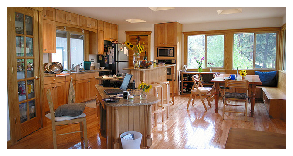

In [19]:
img = open_image(img_dir/images[3])
show_image(img, figsize=(5,5))
img.shape

In [20]:
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

In [21]:
#Check if we have images without annotations
for idx, lbl in enumerate(lbl_bbox):
    if len(lbl[1]) == 0:
        print(f"found empty annotation: {idx}")

In [22]:
data = (ObjectItemList.from_folder(coco)
        #Where are the images? -> in coco and its subfolders
        .split_by_rand_pct(valid_pct=0.1, seed=0)                          
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func)
        #How to find the labels? -> use get_y_func on the file name of the data
        .transform(get_transforms(), size=sz, tfm_y=True)
        #Data augmentation? -> Standard transforms; also transform the label images
        .databunch(bs=8, collate_fn=bb_pad_collate))   
        #Finally we convert to a DataBunch, use a batch size of 16,
        # and we use bb_pad_collate to collate the data into a mini-batch

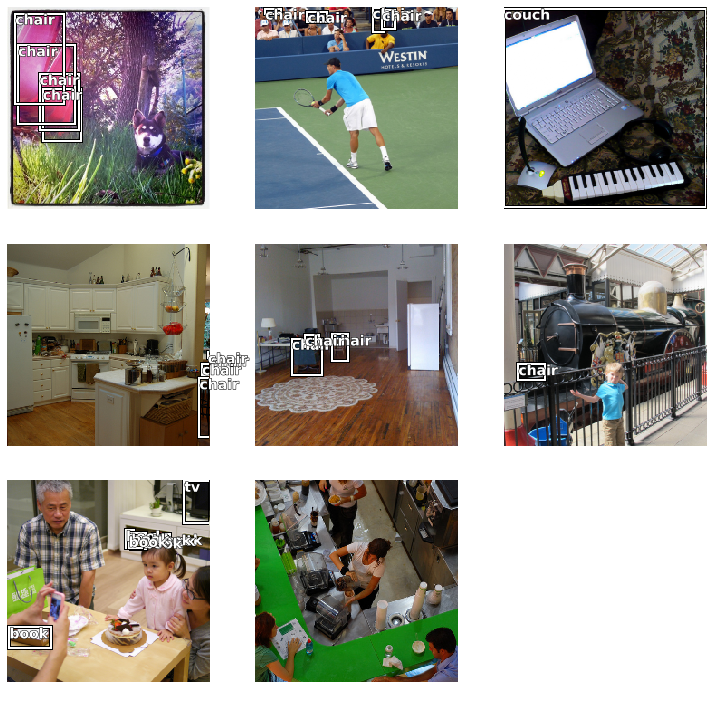

In [23]:
data.show_batch(rows=3, ds_type=DatasetType.Valid, figsize=(10,10))

In [24]:
data

ImageDataBunch;

Train: LabelList (19654 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /home/gosia/.fastai/data/coco_sample;

Valid: LabelList (2183 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /home/gosia/.fastai/data/coco_sample;

Test: None

In [25]:
data.train_ds.y.classes

['background', 'book', 'chair', 'couch', 'remote', 'tv', 'vase']

## Model

In [26]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))

In [27]:
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

In [28]:
class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, 4*k, 3, padding=1) # first bboxes
        self.oconv2 = nn.Conv2d(nin, (ncat+1)*k, 3, padding=1) # than class labels
        self.oconv2.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]

In [29]:
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512,256, stride=1)
#         self.sconv1 = StdConv(256,256)
        self.sconv2 = StdConv(256,256)
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
#         x = self.sconv1(x)
        x = self.sconv2(x)
        return self.out(x)

In [30]:
head_reg4 = SSD_Head(k=1, bias=-3.)
learn = cnn_learner(data, models.resnet34, custom_head=head_reg4)

In [31]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
___________________________________________________

## Play with the loss function

In [32]:
# get one item from the data and prepare it for putting it through the model
itemno = 1
item = data.valid_ds[itemno][0]
x, y = data.one_item(item)
# get one batch of data (x - img, y - ground truth)
#x, y = data.one_batch(cpu=False)

In [33]:
item, x, y

(Image (3, 224, 224),
 tensor([[[[0.5641, 0.5844, 0.6877,  ..., 0.8455, 0.8680, 0.8662],
           [0.6435, 0.6123, 0.6592,  ..., 0.8799, 0.8333, 0.8231],
           [0.5855, 0.5304, 0.5830,  ..., 0.9033, 0.8678, 0.8207],
           ...,
           [0.2992, 0.3033, 0.3037,  ..., 0.4704, 0.4698, 0.4806],
           [0.3165, 0.3342, 0.3403,  ..., 0.4771, 0.4710, 0.4667],
           [0.3205, 0.3302, 0.3180,  ..., 0.4648, 0.4641, 0.4695]],
 
          [[0.3466, 0.3810, 0.4762,  ..., 0.8556, 0.8850, 0.8811],
           [0.3960, 0.3767, 0.4175,  ..., 0.9031, 0.8771, 0.8079],
           [0.3584, 0.3046, 0.3648,  ..., 0.9320, 0.8716, 0.6623],
           ...,
           [0.4277, 0.4294, 0.4273,  ..., 0.5763, 0.5757, 0.5865],
           [0.4471, 0.4536, 0.4582,  ..., 0.5830, 0.5768, 0.5736],
           [0.4526, 0.4456, 0.4317,  ..., 0.5706, 0.5700, 0.5754]],
 
          [[0.2665, 0.3070, 0.3664,  ..., 0.8540, 0.8814, 0.8575],
           [0.3493, 0.3242, 0.3604,  ..., 0.9088, 0.8798, 0.8142],
  

In [34]:
# run the item through the model, get bboxes and classes
b_clas, b_bb = learn.model(x)

In [35]:
b_clas.shape, b_bb.shape

(torch.Size([1, 16, 4]), torch.Size([1, 16, 7]))

In [36]:
# get the first (and only) item from the result batch to examine
idx = 0
b_clasi = b_clas[idx]
b_bboxi = b_bb[idx]

In [37]:
b_clasi.shape, b_bboxi.shape, b_clasi[0], b_bboxi[0]

(torch.Size([16, 4]),
 torch.Size([16, 7]),
 tensor([-1.2201, -0.0178, -0.8642,  2.0349], device='cuda:0',
        grad_fn=<SelectBackward>),
 tensor([-1.7290,  0.6921,  0.3911,  2.2546, -0.5825, -0.7901, -0.6545],
        device='cuda:0', grad_fn=<SelectBackward>))

In [38]:
# get the itemno item from the ground truth
label = data.valid_ds[itemno][1]
bbox, clas = label.data
bbox = bbox.cuda()
clas = torch.tensor(clas).cuda()
bboxi = bbox
clasi = clas

In [39]:
bboxi.shape, clasi.shape, bboxi, clasi

(torch.Size([4, 4]),
 torch.Size([4]),
 tensor([[-0.9910, -0.9073, -0.9416, -0.7544],
         [-0.9997,  0.1552, -0.7628,  0.2663],
         [-0.9600, -0.4887, -0.8562, -0.2979],
         [-0.9791,  0.2508, -0.7892,  0.3821]], device='cuda:0'),
 tensor([2, 2, 2, 2], device='cuda:0'))

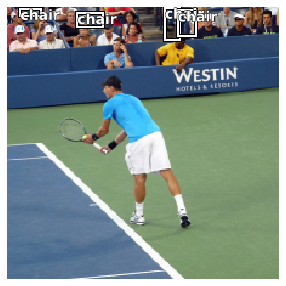

In [40]:
# look at it
item.show(y=label, figsize=(5,5))

### Create anchor boxes

In [41]:
# create a tensor with anchor boxes - middles + sizes
# coordinates of bboxes are scaled to -1,1, so anchor boxes must be too
ncells = 4
k = 1 # num boxes per cell
first_ctr = -1 + 2/(2*ncells)
last_ctr  =  1 - 2/(2*ncells)
a_x = np.repeat(np.linspace(first_ctr, last_ctr, ncells), ncells)
a_y = np.tile(np.linspace(first_ctr, last_ctr, ncells), ncells)
a_sz = np.array([2/ncells for _ in a_x])
anchors = torch.tensor(np.stack([a_x, a_y, a_sz, a_sz], axis=1)).type(torch.FloatTensor).cuda()
anchors

tensor([[-0.7500, -0.7500,  0.5000,  0.5000],
        [-0.7500, -0.2500,  0.5000,  0.5000],
        [-0.7500,  0.2500,  0.5000,  0.5000],
        [-0.7500,  0.7500,  0.5000,  0.5000],
        [-0.2500, -0.7500,  0.5000,  0.5000],
        [-0.2500, -0.2500,  0.5000,  0.5000],
        [-0.2500,  0.2500,  0.5000,  0.5000],
        [-0.2500,  0.7500,  0.5000,  0.5000],
        [ 0.2500, -0.7500,  0.5000,  0.5000],
        [ 0.2500, -0.2500,  0.5000,  0.5000],
        [ 0.2500,  0.2500,  0.5000,  0.5000],
        [ 0.2500,  0.7500,  0.5000,  0.5000],
        [ 0.7500, -0.7500,  0.5000,  0.5000],
        [ 0.7500, -0.2500,  0.5000,  0.5000],
        [ 0.7500,  0.2500,  0.5000,  0.5000],
        [ 0.7500,  0.7500,  0.5000,  0.5000]], device='cuda:0')

In [42]:
# centre+height/width -> corners
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

In [43]:
# create a tensor with anchor corners
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])
anchor_cnr

tensor([[-1.0000, -1.0000, -0.5000, -0.5000],
        [-1.0000, -0.5000, -0.5000,  0.0000],
        [-1.0000,  0.0000, -0.5000,  0.5000],
        [-1.0000,  0.5000, -0.5000,  1.0000],
        [-0.5000, -1.0000,  0.0000, -0.5000],
        [-0.5000, -0.5000,  0.0000,  0.0000],
        [-0.5000,  0.0000,  0.0000,  0.5000],
        [-0.5000,  0.5000,  0.0000,  1.0000],
        [ 0.0000, -1.0000,  0.5000, -0.5000],
        [ 0.0000, -0.5000,  0.5000,  0.0000],
        [ 0.0000,  0.0000,  0.5000,  0.5000],
        [ 0.0000,  0.5000,  0.5000,  1.0000],
        [ 0.5000, -1.0000,  1.0000, -0.5000],
        [ 0.5000, -0.5000,  1.0000,  0.0000],
        [ 0.5000,  0.0000,  1.0000,  0.5000],
        [ 0.5000,  0.5000,  1.0000,  1.0000]], device='cuda:0')

In [44]:
grid_sizes = torch.tensor(np.array([2/ncells]), requires_grad=False).type(torch.FloatTensor).unsqueeze(1).cuda()
grid_sizes

tensor([[0.5000]], device='cuda:0')

### Jaccard index (intersection over union)

In [45]:
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

### Testing loss function components

In [46]:
# computer jaccard index for each pair of bbox / anchor box
overlaps = jaccard(bbox.data.cuda(), anchor_cnr)
overlaps

tensor([[0.0302, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1053, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0792, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0998, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       device='cuda:0')

In [47]:
overlaps.max(1)

torch.return_types.max(
values=tensor([0.0302, 0.1053, 0.0792, 0.0998], device='cuda:0'),
indices=tensor([0, 2, 1, 2], device='cuda:0'))

In [48]:
overlaps.max(0)

torch.return_types.max(
values=tensor([0.0302, 0.0792, 0.1053, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       device='cuda:0'),
indices=tensor([0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))

In [49]:
gt_overlap, gt_idx = map_to_ground_truth(overlaps)
gt_overlap, gt_idx

(tensor([1.9900, 1.9900, 1.9900, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        device='cuda:0'),
 tensor([0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))

In [50]:
gt_clas = clas[gt_idx]; gt_clas

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')

In [51]:
thresh = 0.5
pos = gt_overlap > thresh
pos_idx = torch.nonzero(pos)[:,0]
neg_idx = torch.nonzero(~pos)[:,0]
pos_idx

tensor([0, 1, 2], device='cuda:0')

In [52]:
a_ic = actn_to_bb(b_bboxi, anchors)
gt_bbox = bbox.cuda()[gt_idx]
loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
clas_loss  = F.cross_entropy(b_clasi, gt_clas)
loc_loss,clas_loss

RuntimeError: The size of tensor a (5) must match the size of tensor b (2) at non-singleton dimension 1

In [ ]:
a_ic[pos_idx] - gt_bbox[pos_idx]

## Loss

In [ ]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
#         t = t[:,:-1].contiguous().cuda()
#         x = pred[:,:-1]
        # in fastai v1, the background is encoded as the first class, rather than the last one
        t = t[:,1:].contiguous().cuda()
        x = pred[:,1:]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self,x,t): return None

loss_f = BCE_Loss(ncat)

In [ ]:
# remove padding - images in a minibatch will have a different number of objects
# those with fewer objects will have their bbox groundtruth tensor padded with 0s
def get_y(bbox,clas):
    bbox = bbox.view(-1,4)/sz
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return bbox[bb_keep],clas[bb_keep]

def ssd_1_loss(pred_bbox,pred_clas,bbox,clas):
    bbox,clas = get_y(bbox,clas)
    if len(bbox) == 0 and len(clas) == 0:
        return 0.0, 0.0
    a_ic = actn_to_bb(pred_bbox, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,False)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[~pos] = 0 # background coded as 0
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(pred_clas, gt_clas)
    return loc_loss, clas_loss

def ssd_loss(pred,targ_bb,targ_c):
    lcs,lls = 0.,0.
#    i = 1
#    for b_c,b_bb,bbox,clas in zip(*pred,targ_bb,targ_c):
    for pr_bb, pr_c, ta_bb, ta_c in zip(*pred, targ_bb, targ_c):
#         print(f"item {i}")
#         if i == 5:
#             pdb.set_trace()
#         i = i+1
#        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas)
        loc_loss, clas_loss = ssd_1_loss(pr_bb, pr_c, ta_bb, ta_c)
        lls += loc_loss
        lcs += clas_loss
#    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs

### testing loss

In [ ]:
targ_bb = torch.Tensor(
       [[[ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [-0.5773, -0.8116,  0.2450, -0.3174]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [-0.1941, -1.0000,  0.1386, -0.6498]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.2239,  0.1045,  0.6860,  0.4252],
         [ 0.1462, -0.8892,  0.3074, -0.7431],
         [ 0.5670, -1.0000,  0.9568, -0.2770]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.3339,  0.1548,  1.0000,  0.8593],
         [ 0.2156,  0.0512,  0.3683,  0.2892],
         [-0.2005, -0.8665,  0.0549, -0.7168],
         [-0.2769, -0.6095, -0.1426, -0.4988],
         [ 0.1396,  0.0973,  0.2541,  0.2825],
         [ 0.2190, -0.4510,  0.8659, -0.1197]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [-1.0000, -1.0000,  1.0000,  1.0000]],

        [[ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [-0.5687, -1.0000,  0.3224, -0.2776],
         [-0.7719, -0.9730, -0.2641, -0.7430]],

        [[-0.7442, -0.4517, -0.5332, -0.1869],
         [-0.1305, -1.0000,  0.8579,  0.1150],
         [-0.5668,  0.4511, -0.1786,  0.9804],
         [-0.1794,  0.3308,  0.4564,  1.0000],
         [-0.0332, -0.1310,  0.0374, -0.0480],
         [-0.5315, -0.3920, -0.4946, -0.3181],
         [-0.5600,  0.4514, -0.1746,  0.9009],
         [-0.1808,  0.3072,  0.4723,  1.0000]]]).type(torch.FloatTensor).cuda()
targ_c = torch.Tensor(
       [[0, 0, 0, 0, 0, 0, 0, 2],
        [0, 0, 0, 0, 0, 0, 0, 2],
        [0, 0, 0, 0, 0, 4, 4, 2],
        [0, 0, 2, 2, 2, 2, 2, 2],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 3],
        [0, 0, 0, 0, 0, 0, 2, 2],
        [5, 3, 3, 2, 4, 4, 2, 3]]
).type(torch.LongTensor).cuda()
pred = ( 
    torch.Tensor([[[ 9.8762e-01, -1.4779e+00, -3.7413e-01,  7.6316e-01],
         [-8.8704e-01, -3.6647e-01, -1.6631e+00,  5.4294e-01],
         [-3.6886e-01,  3.5865e-01, -2.9847e+00,  7.9133e-01],
         [-4.2787e-01, -1.1082e+00,  3.7132e-01, -4.3771e-01],
         [ 4.2307e-01, -2.2128e+00,  1.4614e+00,  1.3040e+00],
         [ 9.9863e-03, -7.0987e-02, -1.3261e+00, -1.2140e+00],
         [ 1.2051e+00,  7.1160e-01, -1.6327e+00, -3.7149e+00],
         [ 2.4880e+00, -1.5547e-01,  1.4005e+00,  5.8206e-01],
         [-1.1396e+00,  2.5760e-01,  8.2457e-01, -1.6578e-01],
         [ 3.2429e-01, -2.0920e+00,  1.6120e+00,  2.9189e+00],
         [ 1.5795e+00,  2.6241e+00,  3.0854e+00, -4.1571e+00],
         [-2.4066e-01,  8.0109e-01,  1.4466e+00, -1.4406e+00],
         [ 1.6447e-01,  1.0865e+00, -5.2702e-01,  3.2107e+00],
         [ 6.2061e-02, -1.0231e+00,  6.5151e-02, -4.0982e-01],
         [ 8.8096e-01,  9.8133e-01, -1.7138e-01, -8.5033e-01],
         [ 5.5017e-02, -7.0455e-01, -1.0533e+00, -1.1156e+00]],

        [[-3.6335e-01,  3.8918e-01,  5.4931e-02, -7.8702e-01],
         [-9.7280e-01,  8.4229e-01,  1.1926e+00,  1.1688e+00],
         [-8.9654e-01,  1.3314e-01, -3.8713e-02,  4.5168e-01],
         [-2.0598e+00, -8.6963e-01, -1.7116e-01,  1.1723e-01],
         [ 3.2660e-01, -1.0324e+00,  1.0895e+00,  9.2774e-01],
         [ 1.5087e+00,  1.8403e-01, -1.7000e+00, -1.1123e+00],
         [ 4.3183e+00, -2.2874e+00, -3.9244e+00,  1.7500e-01],
         [ 1.1622e+00,  1.3400e+00, -6.6650e-01,  8.2621e-01],
         [ 1.2424e+00, -6.9241e-01,  5.4183e-01, -5.6754e-01],
         [ 2.7212e-01,  2.2016e+00, -2.5627e+00,  8.1597e-01],
         [ 1.2108e+00,  5.2577e-01, -1.4421e+00,  2.1711e+00],
         [ 1.4584e+00, -3.8627e-02,  9.5446e-01,  4.8601e-01],
         [-3.2541e-01,  6.7044e-01, -6.3449e-01,  2.6857e-01],
         [ 1.2705e+00,  2.1366e-01, -1.4253e-01,  4.6944e-01],
         [-1.3290e+00,  2.1038e+00,  9.3123e-01, -1.3080e+00],
         [ 1.6879e-01, -1.3051e+00,  7.4669e-01, -5.5858e-01]],

        [[-9.9799e-01, -1.6655e+00,  7.7740e-01, -1.7380e+00],
         [ 5.8076e-01, -4.9100e-01,  4.7743e-01,  1.5720e+00],
         [ 5.6013e-01, -2.4031e-01, -2.2442e+00,  1.7093e+00],
         [-2.9173e-01,  1.0343e+00, -4.1351e-01,  8.7000e-01],
         [ 9.7690e-01, -9.7203e-01,  1.3008e-01, -4.8959e-01],
         [ 1.0904e+00, -9.4026e-01,  4.1036e-01,  1.8021e-01],
         [ 1.5822e+00, -2.0986e-01, -2.0912e+00, -6.1775e-01],
         [ 8.8336e-01,  8.8624e-01, -6.4890e-01,  3.8894e-01],
         [ 1.0128e+00, -1.1896e-01,  9.7924e-01, -2.5266e+00],
         [ 1.0548e+00,  8.2748e-01, -9.1007e-02,  6.2163e-01],
         [-1.1999e+00, -1.5553e+00, -3.7140e-01, -1.8970e-01],
         [-4.1276e-01,  4.8228e-01,  6.1935e-01,  1.4614e+00],
         [ 1.8282e-01, -7.5044e-01, -1.2121e+00,  1.3115e+00],
         [-1.8659e+00,  1.2144e+00, -7.1278e-01,  2.9271e-01],
         [-2.9229e+00,  1.4161e+00, -8.7050e-02, -1.6707e+00],
         [ 1.8254e-01, -8.8471e-01, -1.7977e+00, -1.6370e+00]],

        [[ 2.1128e+00,  1.0860e-01,  3.0190e-01,  6.1415e-01],
         [-8.5706e-01, -1.2137e+00,  1.8212e+00,  1.0853e+00],
         [-2.9928e+00,  9.4612e-01,  8.6528e-01, -7.7775e-04],
         [-2.9758e-01,  1.6221e+00, -1.5494e+00, -5.1459e-01],
         [ 3.5226e-02, -7.0568e-01,  2.7147e+00, -1.7411e+00],
         [ 3.5694e+00,  6.6917e-01,  5.6634e-02, -3.0909e+00],
         [-4.8511e-01,  4.9836e-01,  3.2412e+00, -3.6684e+00],
         [ 4.7739e-01,  1.6331e+00,  7.5005e-02, -8.7490e-01],
         [ 3.0658e+00,  1.5753e+00,  2.1871e-01, -9.6214e-01],
         [-2.5041e+00,  7.1017e-01, -6.3999e-01, -8.3989e-01],
         [-3.3680e+00, -3.5563e-01, -5.2665e-01, -6.4132e-01],
         [-1.6401e+00, -7.9923e-01, -1.4134e-01, -2.6607e+00],
         [ 5.9128e-01,  5.1794e-01, -5.8405e-01,  1.4400e+00],
         [-7.6726e-01,  4.5919e-01, -4.4848e-01,  1.8322e+00],
         [ 7.0368e-01, -5.1890e-01,  4.0754e-01, -1.6665e+00],
         [ 1.8708e-01, -6.5611e-01, -1.1814e+00, -8.3318e-03]],

        [[ 9.7350e-01, -1.2468e+00, -1.6553e+00, -4.5054e-01],
         [-6.1881e-01, -5.6009e-01, -5.0877e-01,  1.5835e+00],
         [-1.3718e+00, -1.6417e+00, -8.3399e-02,  1.1808e+00],
         [-1.2528e+00, -1.3424e+00,  1.2231e+00,  1.1334e+00],
         [-9.4864e-01, -1.4376e+00,  2.0369e-01,  9.7490e-01],
         [-1.3080e-01, -3.1644e+00, -6.4770e-02, -1.5374e+00],
         [ 3.7973e+00,  1.6705e+00, -3.9167e-01, -4.0786e-01],
         [ 4.3948e-01,  2.2019e-01,  3.0601e-01,  5.2309e-01],
         [-3.2031e-01,  8.3739e-01,  5.4256e-01,  9.0785e-01],
         [-1.8237e+00, -2.1393e+00,  4.1772e-01, -2.1828e+00],
         [-8.0046e-01, -1.4561e+00,  7.2734e-01,  7.7227e-01],
         [ 1.7779e+00,  1.1563e+00,  2.5623e+00, -1.3468e-01],
         [-2.5091e-01, -2.8684e-01, -4.8146e-02,  1.7337e+00],
         [ 6.9985e-01, -2.0713e+00, -3.0118e-01, -2.6445e-01],
         [ 1.1677e+00, -1.9713e+00, -7.3322e-01, -1.4794e+00],
         [-1.2308e+00, -1.2417e-02, -4.3579e-01, -8.9600e-01]],

        [[ 8.4304e-01, -1.2817e+00, -5.7612e-01,  4.3764e-01],
         [-1.8812e+00, -1.9067e+00,  6.6610e-01,  1.6611e+00],
         [-1.0224e+00, -2.1407e+00,  3.3380e-01,  1.4480e+00],
         [ 1.5430e+00,  1.0706e+00, -1.5705e-01,  1.3305e+00],
         [-6.3939e-01,  2.3279e+00, -1.8405e-01, -3.0192e-01],
         [ 1.9235e+00,  2.0409e+00, -1.3180e+00,  7.7984e-01],
         [ 3.6110e-01,  3.8963e+00,  4.0295e-01, -1.7370e+00],
         [ 1.1676e+00,  3.2536e+00, -3.8783e-01, -1.5728e+00],
         [ 4.2584e-01,  5.7092e-01, -2.0371e-01,  6.2186e-01],
         [-1.8316e+00,  1.0705e+00, -3.4733e+00,  9.3664e-01],
         [-1.3866e+00,  1.7691e+00, -8.0247e-01,  1.7503e+00],
         [-1.0053e+00,  2.4599e+00,  3.0443e+00, -1.6937e+00],
         [ 3.7826e-01, -2.3206e-01,  8.8066e-01,  2.2008e-01],
         [-9.1389e-01, -2.6853e+00,  5.1755e-02,  7.0321e-01],
         [-1.0872e+00, -2.4099e-01, -3.9202e-01,  2.7187e+00],
         [-2.2978e+00, -3.0067e+00,  7.1748e-01,  2.3891e-01]],

        [[-5.2655e-01, -6.2829e-01, -6.4447e-01,  1.6379e+00],
         [ 1.2848e+00, -2.5776e+00, -1.1887e-01, -2.6898e+00],
         [-4.3972e-01,  2.7018e+00, -1.2186e+00, -1.1197e+00],
         [-6.7009e-02,  8.1210e-01,  1.8239e+00,  1.4609e-01],
         [-1.4655e-02, -1.4574e+00,  2.1804e+00, -3.3018e-01],
         [-5.0582e+00, -3.5163e+00, -2.3044e+00,  7.2343e-02],
         [ 1.4252e+00, -2.7019e+00, -1.5882e+00, -1.0083e+00],
         [-3.4446e-01,  1.5283e+00,  2.6233e-01, -1.1137e+00],
         [-6.1303e-01,  6.4650e-01, -8.8444e-01,  2.4273e+00],
         [-1.5466e+00, -1.0116e+00,  6.2452e-01, -1.6006e+00],
         [ 1.2761e+00,  1.9998e+00,  1.6527e+00,  4.7787e-01],
         [ 3.4395e-01,  8.5278e-01,  1.3697e+00,  9.0471e-01],
         [ 5.3363e-01, -2.4605e-01, -3.8785e-01, -8.1037e-01],
         [-5.8584e-01, -5.2581e-01, -1.6174e+00, -2.7848e-01],
         [-8.0427e-01, -1.4803e+00,  1.2001e+00, -6.2241e-01],
         [ 8.5347e-01,  3.4780e-01,  3.1803e-01, -4.4425e-01]],

        [[-3.7653e-01, -7.6040e-01,  1.5344e+00, -1.1890e+00],
         [-1.6478e+00, -1.6497e-01,  8.2820e-01,  1.6917e+00],
         [ 8.4317e-01,  2.2592e+00,  2.3290e+00,  1.7650e-01],
         [-3.7447e-01,  1.2284e+00, -3.6619e-01,  2.3630e-01],
         [ 6.5349e-01, -3.4164e-01,  9.0522e-01,  1.7169e+00],
         [-1.6184e+00,  4.4423e-03, -1.6200e+00, -1.9744e-01],
         [-2.8560e+00,  7.5216e-01,  2.6846e+00, -1.3228e+00],
         [-3.3061e-02,  7.4327e-01,  9.1956e-02,  4.0529e-01],
         [ 1.3544e+00,  8.6200e-01,  9.4125e-01,  1.6663e+00],
         [ 1.5243e+00, -2.5091e+00, -2.3564e-01,  2.5386e+00],
         [-1.6853e-01, -8.3826e-01,  3.5383e-01, -1.0028e+00],
         [-2.0140e+00, -9.9619e-01, -5.7910e-01, -1.7507e-01],
         [-3.7916e-01, -1.6503e+00, -1.6862e+00,  5.6593e-01],
         [-3.4501e-01,  1.3787e+00,  4.1914e-01, -2.7104e-01],
         [-1.8127e-01, -1.0985e+00, -1.0414e+00,  6.0390e-01],
         [-1.0832e+00, -1.4213e+00, -1.8477e+00, -6.4311e-01]]]).type(torch.FloatTensor).cuda(),
    torch.Tensor(
       [[[ 9.8351e-01, -3.1254e-01,  5.8614e-01, -6.8057e-01, -4.9765e-01,
          -1.3579e-01,  8.0230e-01],
         [ 1.1888e+00, -1.9018e-01,  1.4525e+00,  2.4589e+00, -4.5908e-01,
           2.6668e-01,  5.0333e-01],
         [-5.8227e-01,  5.4225e-01, -1.1171e+00, -6.4963e-01, -1.9091e+00,
           1.2025e+00,  1.8606e-01],
         [ 5.1346e-01, -1.4637e-01, -1.2560e+00,  1.5037e-01,  4.0104e-01,
          -9.2993e-01,  2.1474e-01],
         [ 1.0690e+00,  1.8697e-01,  1.5957e-01, -6.2732e-01,  3.7022e-01,
          -9.7993e-01,  3.7552e-01],
         [-9.9164e-01,  4.4478e-01, -1.8997e+00, -1.6996e+00, -4.7070e-01,
           2.4819e-01, -2.1607e+00],
         [ 3.1714e-01,  1.9340e+00,  3.2453e-01, -3.5469e-02,  1.2023e-01,
           8.9277e-01, -1.4815e+00],
         [ 6.3354e-01,  2.1122e+00, -5.7156e-02, -4.4272e-01, -1.7294e-01,
           6.2191e-01,  2.6330e-01],
         [-2.0473e-01, -5.2748e-01,  1.0688e+00, -2.0601e+00, -1.3780e+00,
           1.6150e+00, -6.1833e-01],
         [ 7.3280e-01,  2.0938e+00, -1.1634e+00, -1.1349e+00, -1.3348e+00,
          -1.1279e+00,  5.8998e-01],
         [-1.3567e+00,  1.6318e+00, -1.0948e+00,  2.0525e+00, -1.9265e+00,
          -4.4229e-02, -8.9686e-02],
         [-1.0770e+00, -9.3025e-01, -4.5230e-01, -4.8882e-01,  2.7228e+00,
           1.2379e+00,  7.5546e-01],
         [ 6.8799e-01,  4.6828e-01, -1.1300e+00,  1.0651e-01, -1.2006e+00,
          -1.0059e+00, -1.3031e+00],
         [-1.4966e+00,  1.5881e+00, -2.5317e-01, -7.1354e-01, -1.9078e-01,
          -2.5955e-02, -1.8420e+00],
         [-4.5062e-01,  5.9155e-01,  7.1433e-01, -9.4237e-01, -2.4562e+00,
           1.4090e-01,  3.9380e-01],
         [ 1.4891e+00,  4.8155e-01, -1.3672e+00,  2.7459e-01, -1.2515e+00,
          -3.0676e-01,  1.5812e+00]],

        [[ 2.8781e-01,  1.5249e+00,  1.5081e+00,  5.8316e-01,  5.5434e-01,
          -7.3168e-01, -7.9159e-01],
         [-6.4092e-01, -9.2585e-01, -1.9950e+00, -9.2795e-01, -1.1681e+00,
           1.3081e+00,  1.1338e+00],
         [-9.3310e-01,  4.5814e-01,  9.4320e-02, -2.5676e-01, -9.9191e-02,
          -7.5861e-01,  2.1943e+00],
         [ 7.9116e-01,  1.1820e+00,  1.0300e+00, -6.0247e-01, -6.3214e-01,
          -1.8816e-01,  5.1310e-01],
         [ 3.3420e-01, -1.8076e+00, -7.4973e-01,  1.2129e+00,  1.3904e-01,
           9.0913e-01,  3.4745e-02],
         [-5.9149e-01, -3.4785e+00, -1.8031e+00, -1.2724e+00, -1.3764e+00,
          -1.6139e-01, -8.6156e-02],
         [-3.7015e-01, -1.7079e+00, -6.1352e-01,  1.3399e-01, -1.8572e+00,
           5.6199e-01,  7.0843e-01],
         [ 9.8445e-01, -1.2995e+00, -6.3121e-01, -2.1887e+00, -1.0710e+00,
           1.7024e+00,  1.5544e+00],
         [-1.2394e-01,  1.5681e+00,  1.5744e+00, -1.4870e+00,  1.3976e+00,
          -4.7059e-01, -2.5331e+00],
         [-8.0716e-01, -1.6807e+00, -2.3361e-01,  1.8153e+00,  1.3897e+00,
           3.5556e+00, -4.2170e-02],
         [-1.9173e+00, -7.9895e-01, -6.0891e-01, -1.3234e+00, -8.0983e-01,
          -1.3305e+00, -2.7422e-02],
         [-4.3662e-01, -1.9186e-01,  4.1976e-01, -1.7866e-01, -1.0029e+00,
           5.0971e-01,  4.5508e-01],
         [ 1.4605e+00, -1.4038e+00,  1.3380e-02,  7.0528e-01,  2.0423e+00,
          -1.4423e+00, -4.2221e-01],
         [ 1.4294e+00,  9.7131e-01,  8.1943e-01, -6.6119e-01, -3.9386e-01,
           1.3411e+00, -3.6284e-01],
         [-4.8787e-01,  2.4715e-01,  4.2151e-03,  5.4453e-01, -5.3692e-01,
           1.0442e-01,  4.0765e-01],
         [ 2.7638e-01,  3.7777e-01,  4.9405e-01, -4.3560e-01,  6.8348e-01,
          -3.7069e-01, -2.9216e-01]],

        [[ 6.4952e-01, -5.0487e-01,  3.9449e-02,  2.4530e+00,  7.8983e-01,
          -1.7518e+00,  8.9147e-01],
         [-1.3630e-02, -8.6062e-02,  9.5749e-01,  4.6261e-01,  8.7067e-01,
          -5.8275e-01,  5.8844e-01],
         [-1.8261e-03, -4.8042e-01,  4.2222e-01,  1.2013e+00,  4.0396e-01,
          -4.7004e-01,  2.3084e+00],
         [ 1.3826e+00, -4.3819e-01, -5.5605e-01,  7.6230e-01, -6.5078e-01,
          -8.6020e-01,  1.0341e+00],
         [ 6.2057e-01, -1.3640e+00,  1.9312e+00,  9.9615e-01,  2.2936e+00,
          -1.4837e+00, -2.8933e+00],
         [-2.9965e+00, -6.4009e-02,  1.4761e+00,  1.6601e+00,  2.8932e+00,
           9.5260e-02,  4.8596e-01],
         [-6.3508e-01, -7.6822e-01, -1.5165e+00, -1.1921e+00,  3.0817e-01,
           3.1175e-01, -2.4905e+00],
         [ 4.1958e-01, -1.5572e+00, -3.0404e-02,  3.9388e-01,  1.2570e+00,
          -2.5917e+00, -1.3897e+00],
         [-9.2396e-01,  9.5993e-01,  4.7019e-01, -1.4321e-01,  1.0475e+00,
           4.2438e-01,  7.1689e-01],
         [-1.9541e-01, -1.6842e+00,  1.6070e+00, -2.6648e+00,  1.5853e+00,
          -2.0013e+00, -1.7991e-01],
         [-2.4359e-01,  1.1848e+00, -3.2021e+00,  1.1907e+00, -2.3321e-01,
           1.8682e+00, -2.4548e+00],
         [ 2.5720e+00,  1.8660e+00, -1.1673e+00,  2.5550e+00,  2.7556e+00,
          -2.7177e+00, -6.9268e-01],
         [-7.7578e-02, -4.4270e-01, -7.4647e-01,  4.3800e-01,  5.3031e-01,
          -9.9882e-01, -1.1235e+00],
         [-2.2232e+00, -1.5844e+00,  1.3262e+00, -4.8784e-01,  2.8750e+00,
          -1.3270e+00, -1.0700e+00],
         [-1.8607e-01, -1.0290e+00, -9.4785e-01,  2.2263e+00,  2.7605e+00,
           1.0932e+00,  1.1213e+00],
         [-9.2626e-01,  1.5660e+00, -1.5759e-02, -1.0044e-01, -4.6921e-02,
          -8.0357e-01, -5.4001e-01]],

        [[-3.5668e-01,  8.6253e-01, -1.0119e+00, -6.4628e-01,  2.2484e-01,
           7.5752e-01,  2.2134e-01],
         [-1.2562e+00,  2.0656e-01,  6.8467e-01,  2.2908e-02,  3.7318e-01,
          -1.8911e-01,  8.9595e-02],
         [ 9.4123e-01,  1.9129e+00,  1.0539e-01, -5.1236e-01,  5.7039e-01,
           7.5918e-01, -2.0314e+00],
         [-7.0051e-01,  9.3656e-01, -1.8467e-01,  1.1593e+00, -1.4224e+00,
           1.1582e+00, -3.1964e-01],
         [-2.4415e-01,  2.8055e-01,  2.3396e-01, -3.0301e+00,  1.0093e-01,
           4.7026e-01, -1.5470e+00],
         [-1.3054e+00, -2.4758e+00, -5.9504e-01, -1.8153e+00,  2.1876e+00,
          -1.9939e-01, -1.9518e+00],
         [-2.2236e-01,  4.3371e-01,  1.2575e+00,  1.2430e+00,  3.8428e+00,
           1.9105e+00,  2.2662e-01],
         [ 1.2338e+00, -1.9672e-01, -6.7342e-01, -1.0938e-01,  1.0041e+00,
           5.9417e-01, -7.8684e-01],
         [ 1.2185e+00, -3.2232e-01,  3.0248e-01, -1.6379e+00, -2.5252e+00,
          -6.0584e-01, -1.4383e+00],
         [-3.5646e+00, -2.9862e+00, -6.0270e-02,  1.1665e+00,  7.2438e-01,
          -3.0614e+00, -1.9881e+00],
         [-2.7191e+00, -9.6343e-01, -1.2887e+00,  4.5109e-01, -4.9786e-01,
          -3.8785e+00, -2.9015e+00],
         [-4.1926e-01, -1.9048e-01,  1.0019e+00,  7.9188e-01, -3.1098e-01,
           2.9642e-01,  6.2345e-01],
         [ 4.6224e-01, -8.0373e-01,  3.6326e-01,  1.3060e+00,  1.1285e-01,
          -1.4795e+00, -4.2585e-01],
         [-6.5778e-01, -1.2035e+00,  6.6639e-01,  1.8224e+00, -2.3862e-01,
           1.5087e+00, -6.0044e-01],
         [-4.3973e-01,  1.4565e+00, -9.1808e-01,  9.2063e-01, -1.9571e+00,
          -9.3165e-01,  7.9824e-01],
         [-2.9072e-01,  1.5093e-01, -3.3293e-01, -6.1374e-01,  5.5723e-01,
           3.6560e-01, -8.0880e-01]],

        [[-3.2686e-01,  1.3980e-01,  1.0365e+00,  1.0439e-01,  2.6332e+00,
          -8.9472e-02,  3.9332e-01],
         [-7.2142e-01,  8.2511e-03,  1.4668e-01,  6.3916e-01,  1.9122e+00,
          -9.4583e-01,  7.9465e-01],
         [-4.1833e-01,  1.2598e+00, -1.1409e+00,  1.8256e+00, -2.3478e-01,
          -6.8550e-01, -1.5179e+00],
         [-3.2923e-01,  1.1546e-01,  2.2860e-01,  1.3309e+00, -5.6207e-01,
           4.8485e-01, -3.4572e-01],
         [-1.0807e+00, -3.5097e-02,  7.7910e-02, -2.2506e-01,  1.3755e+00,
          -6.0586e-02,  7.7380e-01],
         [ 7.7796e-01, -7.9345e-01,  4.6567e+00,  2.1288e+00,  3.6262e+00,
           3.7836e-01,  1.0391e+00],
         [-1.3960e+00, -1.2645e+00,  3.5295e+00,  1.4600e+00, -5.2658e-01,
           7.4838e-01, -1.0939e+00],
         [-1.3115e+00, -2.0999e-01,  1.2392e+00,  3.6072e-01,  8.2559e-01,
           7.7504e-01, -2.8946e-02],
         [ 3.6247e-02,  5.1178e-02,  2.1479e+00, -6.5162e-01,  7.2053e-01,
           6.4289e-01, -6.2910e-01],
         [-8.5285e-02,  3.1220e+00,  1.1484e+00, -1.9655e+00, -4.5363e-01,
          -8.4977e-03, -7.6399e-01],
         [ 1.6155e+00,  4.7410e-01,  2.1081e+00,  4.8660e-01, -1.5238e+00,
          -1.4237e+00,  1.4625e+00],
         [-1.4552e+00, -4.3123e-01,  2.5171e+00, -7.8522e-01,  5.8467e-02,
          -5.3754e-01, -4.0191e-01],
         [-1.2028e+00, -7.6512e-01, -7.9168e-02, -7.0353e-01, -2.6218e-02,
          -1.8463e+00,  1.0124e+00],
         [ 1.2164e+00,  1.4462e+00, -1.0742e+00, -2.0820e+00, -1.5252e+00,
          -1.4046e+00, -6.8618e-02],
         [ 7.4890e-01,  2.0780e+00, -3.6235e-01,  1.9534e+00, -4.2809e-01,
          -3.1904e-01, -9.6768e-01],
         [-6.9349e-01,  1.5778e+00, -7.2850e-04,  2.8474e-01,  7.9617e-01,
           7.4329e-01,  2.2623e-01]],

        [[-5.4404e-02, -5.0021e-01, -1.6135e-02, -9.6108e-03,  8.3729e-01,
          -4.3593e-01,  3.4292e-01],
         [ 1.5538e-01, -2.6192e+00,  6.4435e-01,  2.3631e-01, -1.0839e+00,
          -4.5646e-01,  4.7386e-02],
         [-7.2915e-01, -1.0885e+00, -8.1052e-01, -1.0312e+00, -8.4372e-01,
           1.4817e+00,  3.3267e+00],
         [ 3.6910e-01,  5.2019e-01,  6.2773e-01, -1.5380e+00, -2.4602e-01,
           1.0991e+00,  1.4800e+00],
         [ 2.0113e-01, -2.6570e+00, -2.7189e+00, -4.3268e-01, -3.8512e-01,
          -9.6579e-01,  1.3763e+00],
         [-9.5565e-01, -2.2448e+00, -5.5806e-01, -3.9550e-02, -1.5272e+00,
           1.9967e+00,  9.7034e-01],
         [-2.1254e+00,  1.8213e+00, -1.7718e+00,  2.5407e+00, -3.4975e+00,
           3.8787e+00,  2.2849e+00],
         [-1.5408e+00, -1.4722e+00, -2.1937e+00, -4.1961e-01, -1.3715e+00,
           3.3688e-01,  4.3465e+00],
         [-4.5601e-01, -2.0610e+00, -9.7104e-01, -2.4164e-01, -1.7980e+00,
          -1.5188e+00,  8.9054e-01],
         [ 3.3106e-01,  1.4360e+00, -6.8443e-02,  6.7234e-01, -3.3941e+00,
          -3.2562e-01,  4.5008e+00],
         [ 1.2649e+00, -1.2707e+00,  2.0299e+00, -1.7740e-01, -4.8332e+00,
          -2.8384e+00,  4.2395e+00],
         [-1.8839e-01, -1.5775e+00, -4.6898e-01,  3.9582e+00,  1.1909e+00,
          -7.6906e-01,  2.3027e+00],
         [ 3.7799e-01,  1.2900e+00,  4.7810e-01, -4.8570e-01, -4.8683e-01,
          -1.3896e-01, -2.4050e-01],
         [ 2.0659e+00, -1.6734e-01,  1.9969e+00,  7.8828e-01,  2.4077e-01,
          -1.1581e+00, -1.0346e+00],
         [ 4.4948e-01,  7.9348e-01, -1.2421e+00,  1.3682e+00,  1.6201e+00,
          -9.0231e-01, -7.2879e-01],
         [-2.8528e+00,  7.2870e-01,  1.6913e+00,  1.1333e+00,  3.9988e-01,
          -1.0339e+00,  1.6694e+00]],

        [[-4.5178e-02, -1.0214e+00, -3.4417e-01, -1.5750e+00,  8.9976e-01,
          -9.0938e-01,  1.8737e+00],
         [ 1.8126e+00, -1.0990e+00,  8.7209e-01, -1.7383e+00, -9.3357e-01,
           1.0305e+00, -1.5710e+00],
         [-1.3093e+00, -1.7259e+00,  1.3848e+00, -4.1741e-01, -3.1964e+00,
          -9.8067e-01, -6.6654e-01],
         [ 3.4418e-01, -1.6727e+00,  1.9945e-01, -1.0211e+00, -1.6091e+00,
           2.2244e+00, -2.3542e-01],
         [ 7.6407e-01,  2.1074e+00,  9.2091e-01,  1.9067e+00, -8.7510e-01,
           1.9019e-01, -3.0269e-01],
         [-7.1687e-01,  3.1505e+00, -2.6420e+00, -2.1133e+00, -1.3594e+00,
          -4.0212e-01, -2.6141e+00],
         [ 2.6209e-01,  1.9216e+00, -2.6938e+00,  1.2919e+00, -7.7622e-01,
          -4.9807e-02, -6.6339e-01],
         [ 4.6352e-01,  7.1025e-01, -1.1185e+00,  1.2330e+00,  1.0854e+00,
          -9.8187e-02,  2.5945e+00],
         [-1.6009e+00, -1.2166e+00, -8.2164e-01,  3.3558e+00,  3.0158e-01,
           9.0595e-01, -1.6021e+00],
         [ 4.3339e+00, -2.0420e-01, -8.8683e-01, -4.1434e-01, -1.5505e+00,
           2.2793e+00, -4.1568e+00],
         [ 1.9524e+00,  3.2294e-01,  1.0450e+00,  6.3853e-01,  1.0956e+00,
           2.1670e-01, -3.6226e+00],
         [-2.6642e-02, -3.1306e-01,  1.5321e-01,  1.4099e+00,  1.0816e+00,
           3.4097e-01, -7.1780e-02],
         [ 9.4545e-01, -4.6720e-01,  1.0069e+00, -6.0808e-01,  1.0823e+00,
           2.5382e-01, -1.8127e-01],
         [-4.2358e-01,  4.3594e-01, -1.5887e+00, -2.4189e+00, -6.2547e-01,
          -2.4169e+00,  1.2892e+00],
         [-2.0533e-01, -4.4699e-01, -2.0277e+00,  1.4792e+00,  1.8569e+00,
          -6.7096e-01, -5.4032e-01],
         [ 6.3031e-01, -2.7884e+00,  1.8039e-01,  1.2721e+00,  3.4347e-01,
          -8.9682e-01, -5.7290e-01]],

        [[ 3.1665e-01, -1.4792e+00,  4.0502e-01,  3.6555e-01, -1.5641e+00,
           1.1049e+00,  5.8991e-01],
         [-3.9969e-01,  9.5438e-01, -4.2016e-01,  1.9993e+00, -1.2013e+00,
           1.3400e-01,  6.8030e-01],
         [-2.1403e+00, -3.8682e-01, -8.7428e-01, -1.9602e-01, -1.1487e+00,
          -4.6387e-02,  8.1511e-01],
         [-1.1193e+00, -8.2006e-01, -5.9701e-01, -1.4968e+00, -1.3603e-01,
          -1.0960e+00,  1.7132e+00],
         [-1.0670e+00, -1.3927e-01,  7.9046e-01, -2.2007e-01, -7.8251e-01,
          -1.1749e-01, -3.4768e-02],
         [-1.8915e-01, -2.5481e+00, -2.2208e+00,  1.3944e+00, -3.7375e+00,
           1.5275e-01, -1.8989e+00],
         [-4.7623e-01, -1.9915e+00,  2.3380e+00, -1.4242e+00, -2.8057e-02,
           8.2280e-01,  5.5681e-01],
         [-2.4198e+00, -4.2386e-01,  3.0490e-01, -1.2588e+00, -1.2592e+00,
           7.9893e-01, -7.7087e-01],
         [ 7.6134e-01,  4.8202e-01,  2.2129e+00, -5.3871e-01,  2.8114e+00,
           9.3903e-01, -1.0403e+00],
         [-8.4660e-01,  2.5094e-01,  7.6126e-03,  2.3230e+00, -5.5035e-01,
          -6.5701e-01, -1.8341e+00],
         [-2.5409e-01, -8.6439e-01,  1.8643e+00,  1.7575e+00, -3.2512e+00,
           4.7332e-01, -1.1831e+00],
         [-1.3067e-01, -8.3373e-02,  9.8582e-01, -7.9193e-01, -1.8009e+00,
          -2.8376e-01, -8.1730e-01],
         [ 1.3305e-01,  2.6689e-01,  6.1946e-01,  5.6752e-03,  1.5066e+00,
          -7.6551e-01, -1.0903e+00],
         [ 1.1577e+00,  1.5514e+00,  8.8116e-01,  2.7656e-01,  2.7084e-01,
           3.7633e-01, -1.1093e+00],
         [ 1.4273e+00,  4.9179e-02,  1.8996e-01,  1.1608e+00,  3.2394e-02,
          -1.0322e+00, -9.7361e-01],
         [ 9.7741e-01, -6.5999e-01,  1.5808e+00,  1.1995e+00, -5.1358e-02,
          -6.6636e-02, -4.3959e-02]]]).type(torch.FloatTensor).cuda()
)

In [ ]:
ssd_loss(pred,targ_bb,targ_c)

## Train

In [ ]:
head_reg4 = SSD_Head(k=1, bias=-3.)
learn = cnn_learner(data, models.resnet34, loss_func=ssd_loss, custom_head=head_reg4)

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=3e-2
learn.fit_one_cycle(10, lr)

In [ ]:
#learn.fit_one_cycle(5, lr)

In [ ]:
#learn.fit_one_cycle(5, lr)

In [ ]:
#learn.save('bad-model')

In [ ]:
#learn.load('bad-model')

In [ ]:
learn.summary()

In [ ]:
def corners2hw(corners): return torch.cat([corners[:,:2], corners[:,2:] - corners[:,:2]], dim=1)
def show_results(max_show=0, printit=False):
    if max_show == 0:
        max_show = len(data.valid_ds)
    else:
        max_show = min(max_show, len(data.valid_ds))
    figsize = (10, max_show*5)
    fig,axs = plt.subplots(max_show, 2, figsize=figsize)
    i = 0
    while i < max_show:
        img, label = data.valid_ds[i]
        img.show(ax=axs[i,0], y=label, figsize=(5,5))        
        x, _ = data.one_item(img)
        pred_bb, pred_cc = learn.model(x)
        pred_cc = pred_cc.squeeze() # remove the singleton batch dimension
        pred_bb = pred_bb.squeeze()
        pred_clas = pred_cc.max(1)[1] # get the index of the max as the predicted clas
        pred_clas_prob = pred_cc.max(1)[0].sigmoid() # get the sigmoid of the max as the class probability
#         if i == 1:
#             pdb.set_trace()
        a_ic = actn_to_bb(pred_bb, anchors)
        anc_cnr = anchor_cnr.clone()
        if printit:
            print(a_ic)
            print(anc_cnr)
        h = 224
        w = 224
        a_ic.add_(1).mul_(torch.tensor([h/2, w/2, h/2, w/2]).cuda()).long()
        anc_cnr.add_(1).mul_(torch.tensor([h/2, w/2, h/2, w/2]).cuda()).long()
        if printit:
            print(a_ic)
            print(anc_cnr)
        a_ic = corners2hw(a_ic)
        anc_cnr = corners2hw(anc_cnr)
        if printit:
            print(a_ic)
            print(anc_cnr)        
        # select only bboxes that detect something else than background (0)
        pos_idx = pred_clas > 0
        pos_pred_clas = pred_clas[pos_idx]
        pos_a_ic = a_ic[pos_idx]
        if len(pos_pred_clas) > 0:
            pred_label = ImageBBox.create(224, 224, pos_a_ic.cpu(), pos_pred_clas.cpu(), data.train_ds.y.classes)
            #print(pred_clas)
            #print(a_ic)
            img.show(ax=axs[i,1], y=pred_label, figsize=(5,5))
        else:
            img.show(ax=axs[i,1], figsize= (5,5))
        i = i+1
        

#     i
#     while i < max_show:
#     for i,(x,y) in enumerate(data.one_batch(ds_type=DatasetType.Valid)):
#         if i >= max_show:
#             break
#         x.show(ax=axs[i,0], y=y, figsize=(5,5))
#         pred = learn.model(x)
#         #pred.show(ax=axs[i,2], figsize=(5,5), title=f"recall: {r:.2f}, precision: {p:.2f}")

In [2]:
show_results(max_show=2, printit=True)

NameError: name 'data' is not defined

NOTE: Enter 'c' at the ipdb>  prompt to continue execution.
> <string>(2)<module>()

ipdb> c
> <ipython-input-128-e3bce3b946d2>(21)show_results()
-> a_ic = actn_to_bb(pred_bb, anchors)
(Pdb) l
 16  	        pred_bb = pred_bb.squeeze()
 17  	        pred_clas = pred_cc.max(1)[1] # get the index of the max as the predicted clas
 18  	        pred_clas_prob = pred_cc.max(1)[0].sigmoid() # get the sigmoid of the max as the class probability
 19  	        if i == 1:
 20  	            pdb.set_trace()
 21  ->	        a_ic = actn_to_bb(pred_bb, anchors)
 22  	        h = 224
 23  	        w = 224
 24  	        a_ic.add_(1).mul_(torch.tensor([h/2, w/2, h/2, w/2]).cuda()).long()
 25  	        a_ic = corners2hw(a_ic)
 26  	        # select only bboxes that detect something else than background (0)
(Pdb) p pred_b
*** NameError: name 'pred_b' is not defined
(Pdb) p pred_bb
tensor([[  0.1639,  -1.0134,  -4.8974,  -4.8553],
        [ -2.6172,   5.6968,  -8.5957,  -8.6313],
        [ -3.7565,  -6.0970

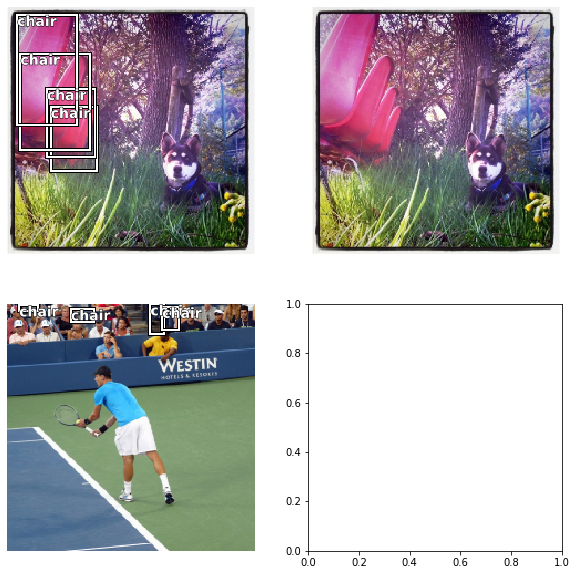

In [130]:
%%debug
show_results(max_show=2)

In [77]:
data.train_ds.y.classes

['background', 'book', 'chair', 'couch', 'remote', 'tv', 'vase']

In [111]:
t = torch.Tensor([-1.0, -1., 1., 1.]).unsqueeze(0)

In [112]:
t[:,:2], t[:,2:], t[:,2:] - t[:,:2]

(tensor([[-1., -1.]]), tensor([[1., 1.]]), tensor([[2., 2.]]))

In [113]:
corners2hw(t)

tensor([[-1., -1.,  2.,  2.]])